In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_parquet("../train_final_v3.parquet")
val_df = pd.read_parquet("../validationA_v3.parquet")

In [3]:
print(train_df.shape)
print(val_df.shape)

(112768, 791)
(24164, 791)


In [4]:
train_df.iloc[:,:25].dtypes

category                            object
missing_price                         bool
item_rank                          float64
match                                int64
avg_rating                         float64
min_rating                           int64
percent_positive                   float64
percent_negative                   float64
avg_verified_reviewers             float64
min_date                    datetime64[ns]
max_date                    datetime64[ns]
product_lifespan           timedelta64[ns]
num_bots_per_asin                    int64
unique_reviewer_count                int64
avg_reviews_per_day                float64
reviews_per_product                  int64
avg_review_length_words            float64
embed_0                            float64
embed_1                            float64
embed_2                            float64
embed_3                            float64
embed_4                            float64
embed_5                            float64
embed_6    

In [5]:
X_train = train_df.drop(columns=['match'], axis=1)
X_val = val_df.drop(columns=['match'], axis=1)
y_train = train_df['match']
y_val = val_df['match']

In [6]:
X_train_raw = X_train
X_val_raw = X_val

## Columns Type Updated

In [7]:
for df in (X_train, X_val):
    df['review_span'] = (df['max_date'] - df['min_date']).dt.days
    df.drop(['min_date', 'max_date'], axis=1, inplace=True)

for df in (X_train, X_val):
    df['missing_price'] = df['missing_price'].astype(int)

for df in (X_train, X_val):
    df['product_lifespan_days'] = df['product_lifespan'].dt.days
    df.drop('product_lifespan', axis=1, inplace=True)

print(f"The shape of X_train: {X_train.shape}, X_val: {X_val.shape}")

The shape of X_train: (112768, 789), X_val: (24164, 789)


We will drop the columns `percent_positive`, `percent_negative`,  `review_span ` and `unique_reviewer_count` as they exhibit high correlation with other features, which may introduce multicollinearity into the model.

In [8]:
for df in (X_train, X_val):
    df.drop(['percent_positive', 'percent_negative', 'unique_reviewer_count', 'review_span'], axis=1, inplace=True)

## Preprocessing, PCA

In [9]:
from typing import List, Tuple
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA



def make_transformer(df,r, s, drop_first=True):
    rev_cols  = [c for c in df if c.startswith("embedding_")]
    summ_cols = [c for c in df if c.startswith("embed_")]
    numeric_cols  = [c for c in df if c not in rev_cols+summ_cols+["category"]]

    rev_pipe  = ("drop" if r == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=r,random_state=42))]))
    sum_pipe  = ("drop" if s == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=s,random_state=42))]))

    return ColumnTransformer(
        [('num', StandardScaler(), numeric_cols),
         ('cat', OneHotEncoder(handle_unknown="ignore", drop="first" if drop_first else None, sparse_output=False), ["category"]),
         ('rev', rev_pipe,  rev_cols),
         ('sum', sum_pipe,  summ_cols)
        ]).set_output(transform="pandas")

In [10]:
preprocessor = make_transformer(X_train, 0.95, 0.95)
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)

In [11]:
# Column Types
num_cols = [c for c in X_train_proc.columns if c.startswith("num__")]
cat_cols       = [c for c in X_train_proc.columns if c.startswith("cat__")]
rev_cols       = [c for c in X_train_proc.columns if c.startswith("rev__")]
sum_cols       = [c for c in X_train_proc.columns if c.startswith("sum__")]

## Multicollinearity: Variance Inflation Factor (VIF) On Non-Embedding Features:

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(X_train_proc, numeric_cols, categorical_cols, thresh=10):
    nonembed_cols = numeric_cols + categorical_cols
    X_vif = X_train_proc[nonembed_cols].copy()

    # drop constant / near-constant columns
    const_cols = X_vif.columns[X_vif.std() < 1e-12]
    if len(const_cols):
        X_vif.drop(columns=const_cols, inplace=True)

    # VIF calculation 
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    # Print features with VIF > 10
    high_vif = vif_data[vif_data["VIF"] > thresh].sort_values("VIF", ascending=False)
    if not high_vif.empty:
        print(f"Features with VIF > {thresh}:")
        print(high_vif.to_string(index=False))
    else:
        print(f"No features with VIF > {thresh}")

    return vif_data

In [13]:
vif_data = compute_vif(X_train_proc, num_cols, cat_cols, thresh=10)

No features with VIF > 10


## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

log_reg = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', class_weight="balanced", random_state=42)
log_reg.fit(X_train_proc, y_train)

y_pred = log_reg.predict(X_val_proc)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

Accuracy: 0.8540390663797385
Confusion Matrix:
 [[20536  3464]
 [   63   101]]
Macro Recall: 0.735760162601626


In [14]:
import sys
from pathlib import Path

project_root = Path().resolve().parent   
sys.path.insert(0, str(project_root / "src"))

## Custom KFold

In [15]:
import sys
sys.path.insert(0, '../Data/')
from get_cv_split import PredefinedKFold
split_data=pd.read_parquet("../Data/CV_val_split.parquet")
assert((split_data.index==X_train.index).all()) # Sanity check to verify indices of X_train match up with indices of split_data
kfold=PredefinedKFold(split_data)

In [17]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

recall_macro_scorer = make_scorer(recall_score, average='macro')

scores = cross_val_score(log_reg, X_train_proc, y_train, cv=kfold, scoring=recall_macro_scorer)

print("Macro Recall (per fold):", scores)
print("Mean Macro Recall:", scores.mean())


Macro Recall (per fold): [0.66175105 0.61062747 0.5902162 ]
Mean Macro Recall: 0.6208649059714831


### GridSearchCV on r and s (The PCA dimension of Review and Summary Embeddings)

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, average_precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe = Pipeline([
    ("fe", make_transformer(X_train, r=50, s=10)),  # Dummy values, will be overridden by grid search
    ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

grid_vals = [10, 20, 50, 100]
param_grid = {
    "fe__rev__pca__n_components": grid_vals,  # r
    "fe__sum__pca__n_components": grid_vals   # s
}

scorers = {
    "pr_auc": make_scorer(average_precision_score, needs_proba=True),
    "recall_macro": make_scorer(recall_score, average="macro"),
    "f1_macro": make_scorer(f1_score, average="macro"),
}

# Run GridSearchCV
gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scorers,
    refit="recall_macro",  
    cv=kfold,              
    n_jobs=20,
    return_train_score=False,
    verbose=1
)

# Fit
gcv.fit(X_train, y_train)  

# Extract results
results = (
    pd.DataFrame(gcv.cv_results_)
    .loc[:, [
        "param_fe__rev__pca__n_components",
        "param_fe__sum__pca__n_components",
        "mean_test_pr_auc", "std_test_pr_auc",
        "mean_test_recall_macro", "std_test_recall_macro",
        "mean_test_f1_macro", "std_test_f1_macro"
    ]]
    .rename(columns={
        "param_fe__rev__pca__n_components": "r",
        "param_fe__sum__pca__n_components": "s",
        "mean_test_pr_auc": "pr_auc_mean",
        "std_test_pr_auc": "pr_auc_std",
        "mean_test_recall_macro": "recall_macro_mean",
        "std_test_recall_macro": "recall_macro_std",
        "mean_test_f1_macro": "f1_macro_mean",
        "std_test_f1_macro": "f1_macro_std"
    })
    .sort_values("recall_macro_mean", ascending=False)
    .reset_index(drop=True)
)

print(results.head())

# Best model ready to use
best_lr = gcv.best_estimator_


From the results, we observe that there is not much difference between the different values of r and s. So, we will choose r = 50 and s = 10 since with these values model performs best.

## Feature Selection With Logistic Regression

#### Preprocessing with r=50, s=10

In [17]:
preprocessor = make_transformer(X_train, r=50, s=10)
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
# update columns names
num_cols = [c for c in X_train_proc.columns if c.startswith("num__")]
cat_cols       = [c for c in X_train_proc.columns if c.startswith("cat__")]
rev_cols       = [c for c in X_train_proc.columns if c.startswith("rev__")]
sum_cols       = [c for c in X_train_proc.columns if c.startswith("sum__")]

print(f"After preprocessing X_train_proc:", X_train_proc.shape)
print(f"After preprocessing X_val_proc:", X_val_proc.shape)

After preprocessing X_train_proc: (112768, 95)
After preprocessing X_val_proc: (24164, 95)


In [18]:
from sklearn.feature_selection import SelectFromModel

l1_model = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', C=0.1, random_state=42)
l1_model.fit(X_train_proc, y_train)

selector = SelectFromModel(l1_model, prefit=True)
X_train_sel = selector.transform(X_train_proc)
selected_feats = X_train_proc.columns[selector.get_support()]

print(f"Selected {len(selected_feats)} features:")
print(selected_feats.tolist())


Selected 519 features:
['num__missing_price', 'num__item_rank', 'num__avg_rating', 'num__min_rating', 'num__avg_verified_reviewers', 'num__num_bots_per_asin', 'num__avg_reviews_per_day', 'num__reviews_per_product', 'num__avg_review_length_words', 'num__mean_sentiment_score', 'num__mean_complaint_similarity', 'num__mean_shipping_similarity', 'num__max_complaint_similarity', 'num__shipping_similarity_at_max_complaint', 'num__sentiment_score_at_max_complaint', 'num__product_lifespan_days', 'cat__category_Arts & Crafts', 'cat__category_Baby & Toddler Toys', 'cat__category_Building Toys', 'cat__category_Dolls & Accessories', 'cat__category_Dress Up & Pretend Play', 'cat__category_Games', 'cat__category_Grown-Up Toys', 'cat__category_Hobbies', "cat__category_Kids' Electronics", "cat__category_Kids' Furniture, Dcor & Storage", 'cat__category_Learning & Education', 'cat__category_Novelty & Gag Toys', 'cat__category_Party Supplies', 'cat__category_Puppets', 'cat__category_Puzzles', 'cat__catego

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


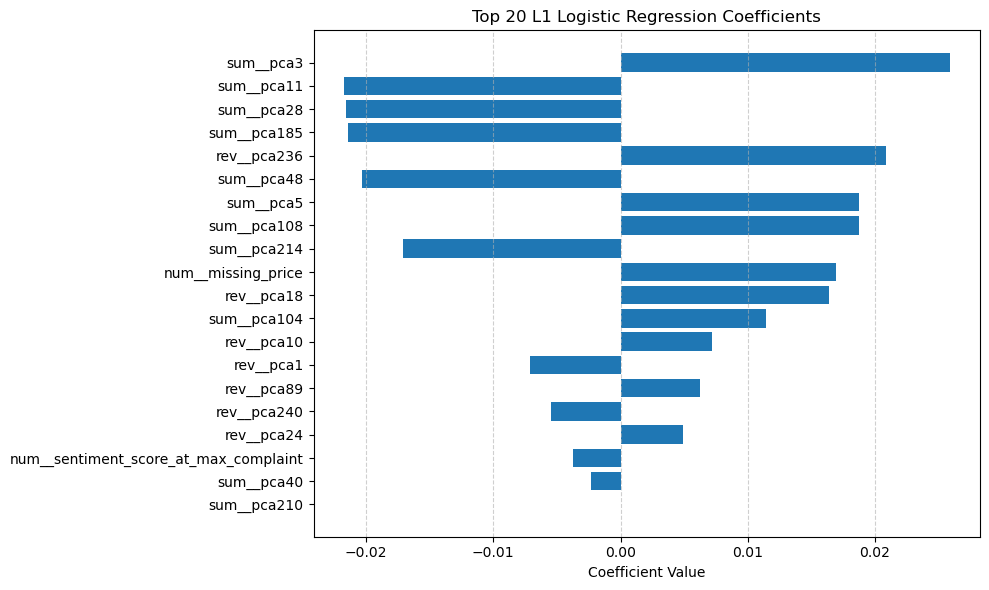

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get coefficients and feature names
coefs = l1_model.coef_[0]
feature_names = X_train_proc.columns

# Create a DataFrame
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_coefficient': np.abs(coefs)
})

# Get top 20 features by absolute coefficient
top20 = coef_df.sort_values(by='abs_coefficient', ascending=False).tail(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top20['feature'][::-1], top20['coefficient'][::-1])
plt.title('Top 20 L1 Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

It looks like category features are very important. We will drop category features and regenerate the featue importance.

In [20]:
# Drop category columns
X_train_proc_wo_cat = X_train_proc.drop(columns=cat_cols, axis=1)
X_val_proc_wo_cat = X_val_proc.drop(columns=cat_cols, axis=1)

print(f"After dropping categorical columns from train dataframe:", X_train_proc_wo_cat.shape)
print(f"After dropping categorical columns from val dataframe:", X_val_proc_wo_cat.shape)

After dropping categorical columns from train dataframe: (112768, 500)
After dropping categorical columns from val dataframe: (24164, 500)


In [21]:
l1_model.fit(X_train_proc_wo_cat, y_train)

selector = SelectFromModel(l1_model, prefit=True)
X_train_sel = selector.transform(X_train_proc_wo_cat)
selected_feats = X_train_proc_wo_cat.columns[selector.get_support()]

print(f"Selected {len(selected_feats)} features:")
print(selected_feats.tolist())


Selected 500 features:
['num__missing_price', 'num__item_rank', 'num__avg_rating', 'num__min_rating', 'num__avg_verified_reviewers', 'num__num_bots_per_asin', 'num__avg_reviews_per_day', 'num__reviews_per_product', 'num__avg_review_length_words', 'num__mean_sentiment_score', 'num__mean_complaint_similarity', 'num__mean_shipping_similarity', 'num__max_complaint_similarity', 'num__shipping_similarity_at_max_complaint', 'num__sentiment_score_at_max_complaint', 'num__product_lifespan_days', 'rev__pca0', 'rev__pca1', 'rev__pca2', 'rev__pca3', 'rev__pca4', 'rev__pca5', 'rev__pca6', 'rev__pca7', 'rev__pca8', 'rev__pca9', 'rev__pca10', 'rev__pca11', 'rev__pca12', 'rev__pca13', 'rev__pca14', 'rev__pca15', 'rev__pca16', 'rev__pca17', 'rev__pca18', 'rev__pca19', 'rev__pca20', 'rev__pca21', 'rev__pca22', 'rev__pca23', 'rev__pca24', 'rev__pca25', 'rev__pca26', 'rev__pca27', 'rev__pca28', 'rev__pca29', 'rev__pca30', 'rev__pca31', 'rev__pca32', 'rev__pca33', 'rev__pca34', 'rev__pca35', 'rev__pca36', 

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


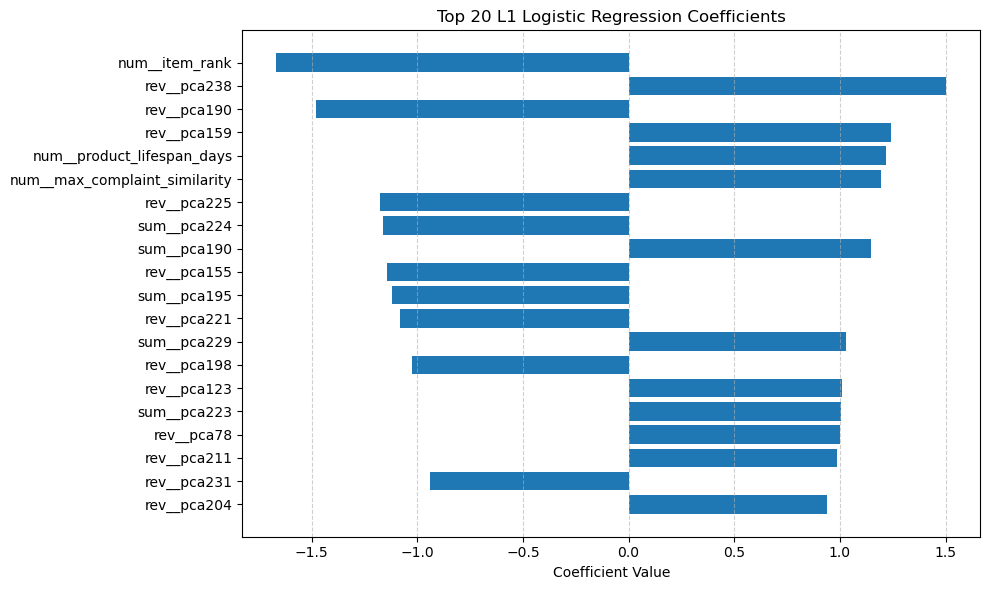

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get coefficients and feature names
coefs = l1_model.coef_[0]
feature_names = X_val_proc_wo_cat.columns

# Create a DataFrame
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_coefficient': np.abs(coefs)
})

# Get top 20 features by absolute coefficient
top20 = coef_df.sort_values(by='abs_coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top20['feature'][::-1], top20['coefficient'][::-1])
plt.title('Top 20 L1 Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

recall_macro_scorer = make_scorer(recall_score, average='macro')

scores = cross_val_score(log_reg, X_train_proc_wo_cat, y_train, cv=kfold, scoring=recall_macro_scorer)

print("Macro Recall (per fold):", scores)
print("Mean Macro Recall:", scores.mean())

Macro Recall (per fold): [0.66983119 0.60721629 0.59617931]
Mean Macro Recall: 0.6244089297628549


In [24]:
log_reg = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', class_weight="balanced", random_state=42)
log_reg.fit(X_train_proc_wo_cat, y_train)

y_pred = log_reg.predict(X_val_proc_wo_cat)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

Accuracy: 0.8386442641946698
Confusion Matrix:
 [[20164  3836]
 [   63   101]]
Macro Recall: 0.728010162601626


Dropping category improves the results. 

Rebekah Testing

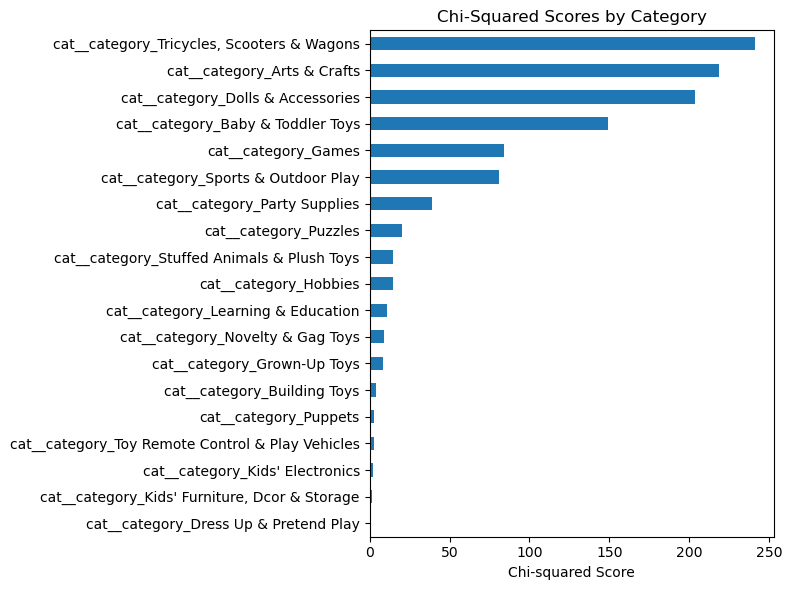

In [25]:
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt

X_train_cat_chi = X_train_proc[cat_cols]
X_val_cat_chi = X_val_proc[cat_cols]

chi_selector = SelectKBest(score_func=chi2, k='all')
chi_selector.fit(X_train_cat_chi, y_train)

chi_scores = pd.Series(chi_selector.scores_, index=X_train_cat_chi.columns).sort_values(ascending=False)

# Keep top k categorical features
top_k_cat = chi_scores.index.tolist()
X_cat_reduced = X_train_cat_chi[top_k_cat]

chi_scores.sort_values(ascending=True).plot(kind='barh', figsize=(8, 6), title='Chi-Squared Scores by Category')
plt.xlabel("Chi-squared Score")
plt.tight_layout()
plt.show()


In [26]:
chi_scores_features = chi_scores[chi_scores > 10].index.to_list()

In [27]:
chi_scores_features

['cat__category_Tricycles, Scooters & Wagons',
 'cat__category_Arts & Crafts',
 'cat__category_Dolls & Accessories',
 'cat__category_Baby & Toddler Toys',
 'cat__category_Games',
 'cat__category_Sports & Outdoor Play',
 'cat__category_Party Supplies',
 'cat__category_Puzzles',
 'cat__category_Stuffed Animals & Plush Toys',
 'cat__category_Hobbies',
 'cat__category_Learning & Education']

In [31]:
X_train_wo_cat = X_train_proc.drop(columns=cat_cols)
X_val_wo_cat = X_val_proc.drop(columns=cat_cols)

In [33]:
log_reg_wo_cat = LogisticRegression(penalty='l1', solver='saga', class_weight={0:1, 1:600}, random_state=42, C=0.10)
log_reg_wo_cat.fit(X_train_proc_wo_cat, y_train)

y_pred = log_reg_wo_cat.predict(X_val_proc_wo_cat)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

Accuracy: 0.6927660983280913
Confusion Matrix:
 [[16621  7379]
 [   45   119]]
Macro Recall: 0.7090757113821138


/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [34]:
log_reg_w_cat = LogisticRegression(penalty='l1', solver='saga', class_weight={0:1, 1:600}, random_state=42, C=10)
log_reg_w_cat.fit(X_train_proc, y_train)

y_pred = log_reg_w_cat.predict(X_val_proc)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

Accuracy: 0.734936268829664
Confusion Matrix:
 [[17634  6366]
 [   39   125]]
Macro Recall: 0.7484725609756098


/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_wo_cat = RandomForestClassifier(n_estimators=400,
                                   min_samples_split=5,
                                   min_samples_leaf=3,
                                   max_features='log2',
                                   max_depth=7,
                                   class_weight={0: 1.0, 1: 600.0})

rf_wo_cat.fit(X_train_proc_wo_cat, y_train)

y_pred = rf_wo_cat.predict(X_val_proc_wo_cat)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)



Accuracy: 0.4399106108260222
Confusion Matrix:
 [[10480 13520]
 [   14   150]]
Macro Recall: 0.675650406504065


In [36]:

rf_w_cat = RandomForestClassifier(n_estimators=300,
                                   min_samples_split=10,
                                   min_samples_leaf=3,
                                   max_features='log2',
                                   max_depth=7,
                                   class_weight={0: 1.0, 1: 600.0})

rf_w_cat.fit(X_train_proc, y_train)

y_pred = rf_w_cat.predict(X_val_proc)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

Accuracy: 0.45662969707002155
Confusion Matrix:
 [[10886 13114]
 [   16   148]]
Macro Recall: 0.6780111788617886


In [37]:
from xgboost import XGBClassifier

xgb_wo_cat = XGBClassifier(
    max_depth = 3,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 1,
    reg_alpha = 1,
    reg_lambda = 1,
    scale_pos_weight = 600
)

xgb_wo_cat.fit(X_train_proc_wo_cat, y_train)

y_pred = xgb_wo_cat.predict(X_val_proc_wo_cat)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

Accuracy: 0.5590547922529383
Confusion Matrix:
 [[13362 10638]
 [   17   147]]
Macro Recall: 0.7265457317073171


In [38]:
xgb_w_cat = XGBClassifier(
    max_depth = 3,
    learning_rate = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.8,
    reg_alpha = 0,
    reg_lambda = 1,
    scale_pos_weight = 600
)

xgb_w_cat.fit(X_train_proc, y_train)

y_pred = xgb_w_cat.predict(X_val_proc)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

Accuracy: 0.5943552391988082
Confusion Matrix:
 [[14213  9787]
 [   15   149]]
Macro Recall: 0.7503724593495935


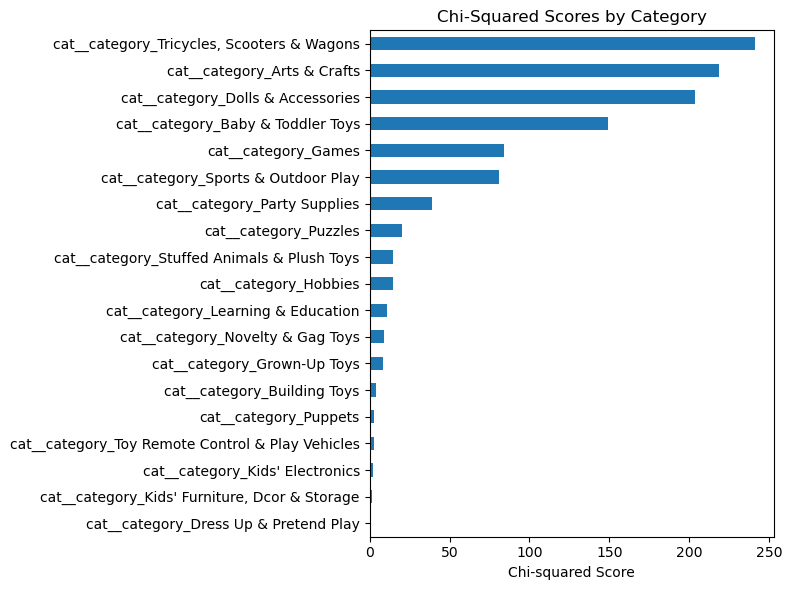

In [39]:
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt

X_train_cat_chi = X_train_proc[cat_cols]
X_val_cat_chi = X_val_proc[cat_cols]

chi_selector = SelectKBest(score_func=chi2, k='all')
chi_selector.fit(X_train_cat_chi, y_train)

chi_scores = pd.Series(chi_selector.scores_, index=X_train_cat_chi.columns).sort_values(ascending=True)

# Keep top k categorical features
top_k_cat = chi_scores.index.tolist()
X_cat_reduced = X_train_cat_chi[top_k_cat]

chi_scores.sort_values(ascending=True).plot(kind='barh', figsize=(8, 6), title='Chi-Squared Scores by Category')
plt.xlabel("Chi-squared Score")
plt.tight_layout()
plt.show()


In [40]:
low_chi_features = chi_scores[chi_scores < 10].index.to_list()

In [41]:
chi_scores_features

['cat__category_Tricycles, Scooters & Wagons',
 'cat__category_Arts & Crafts',
 'cat__category_Dolls & Accessories',
 'cat__category_Baby & Toddler Toys',
 'cat__category_Games',
 'cat__category_Sports & Outdoor Play',
 'cat__category_Party Supplies',
 'cat__category_Puzzles',
 'cat__category_Stuffed Animals & Plush Toys',
 'cat__category_Hobbies',
 'cat__category_Learning & Education']

In [42]:
wo_cat = list(X_train_proc_wo_cat.columns)
high_chi_cat = wo_cat + chi_scores_features
X_train_high_chi = X_train_proc[high_chi_cat]
X_train_high_chi

,num__missing_price,num__item_rank,num__avg_rating,num__min_rating,num__avg_verified_reviewers,num__num_bots_per_asin,num__avg_reviews_per_day,num__reviews_per_product,num__avg_review_length_words,num__mean_sentiment_score,...,cat__category_Arts & Crafts,cat__category_Dolls & Accessories,cat__category_Baby & Toddler Toys,cat__category_Games,cat__category_Sports & Outdoor Play,cat__category_Party Supplies,cat__category_Puzzles,cat__category_Stuffed Animals & Plush Toys,cat__category_Hobbies,cat__category_Learning & Education
164452,1.049033,-0.161466,-0.237963,0.382759,-0.577924,-0.147503,-0.206234,0.007601,0.986011,-0.174997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140060,-0.953258,0.172389,0.790299,0.382759,0.485576,-0.147503,0.733557,-0.197906,-0.486856,0.717107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388375,1.049033,-0.718802,0.254746,0.382759,0.485576,-0.147503,0.193645,0.051638,-0.295929,0.515494,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345889,-0.953258,-0.908088,0.415412,0.382759,0.485576,-0.147503,0.100069,0.051638,-0.641417,0.110165,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
366219,1.049033,0.257471,-0.173697,-0.662956,0.485576,-0.147503,0.084291,-0.197906,-0.790782,0.718429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537509,-0.953258,-0.205032,-3.065682,-3.800100,0.485576,-0.147503,0.084291,-0.197906,-0.697266,-2.515719,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
542506,1.049033,-0.330414,0.211901,0.382759,-0.312049,-0.147503,-0.171539,-0.139190,0.462325,0.039811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
542888,1.049033,-0.949964,-0.001555,0.382759,-0.084156,-0.147503,0.092195,0.198429,0.494220,-0.084088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
543676,-0.953258,-1.215715,-0.077297,0.382759,0.186466,-0.147503,-0.122053,0.374577,-0.331387,-0.190389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
wo_cat = list(X_train_proc_wo_cat.columns)
low_chi_cat = wo_cat + low_chi_features
X_train_low_chi = X_train_proc[low_chi_cat]
X_train_low_chi

,num__missing_price,num__item_rank,num__avg_rating,num__min_rating,num__avg_verified_reviewers,num__num_bots_per_asin,num__avg_reviews_per_day,num__reviews_per_product,num__avg_review_length_words,num__mean_sentiment_score,...,sum__pca241,sum__pca242,cat__category_Dress Up & Pretend Play,"cat__category_Kids' Furniture, Dcor & Storage",cat__category_Kids' Electronics,cat__category_Toy Remote Control & Play Vehicles,cat__category_Puppets,cat__category_Building Toys,cat__category_Grown-Up Toys,cat__category_Novelty & Gag Toys
164452,1.049033,-0.161466,-0.237963,0.382759,-0.577924,-0.147503,-0.206234,0.007601,0.986011,-0.174997,...,-0.064263,-0.024298,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
140060,-0.953258,0.172389,0.790299,0.382759,0.485576,-0.147503,0.733557,-0.197906,-0.486856,0.717107,...,-0.002783,-0.005540,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
388375,1.049033,-0.718802,0.254746,0.382759,0.485576,-0.147503,0.193645,0.051638,-0.295929,0.515494,...,0.283996,-0.193200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345889,-0.953258,-0.908088,0.415412,0.382759,0.485576,-0.147503,0.100069,0.051638,-0.641417,0.110165,...,0.245343,-0.263603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
366219,1.049033,0.257471,-0.173697,-0.662956,0.485576,-0.147503,0.084291,-0.197906,-0.790782,0.718429,...,-0.008646,0.031422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537509,-0.953258,-0.205032,-3.065682,-3.800100,0.485576,-0.147503,0.084291,-0.197906,-0.697266,-2.515719,...,0.054891,0.072908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
542506,1.049033,-0.330414,0.211901,0.382759,-0.312049,-0.147503,-0.171539,-0.139190,0.462325,0.039811,...,0.494409,-0.641887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
542888,1.049033,-0.949964,-0.001555,0.382759,-0.084156,-0.147503,0.092195,0.198429,0.494220,-0.084088,...,0.320675,-0.034433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
543676,-0.953258,-1.215715,-0.077297,0.382759,0.186466,-0.147503,-0.122053,0.374577,-0.331387,-0.190389,...,-0.043480,-0.259872,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
from sklearn.metrics import average_precision_score
xgb_low_chi = XGBClassifier(
    max_depth = 3,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 1,
    reg_alpha = 1,
    reg_lambda = 1,
    scale_pos_weight = 600
)

xgb_low_chi.fit(X_train_low_chi, y_train)

y_pred = xgb_low_chi.predict(X_val_proc[low_chi_cat])
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

print(f'PR AUC:{average_precision_score(y_val,y_pred)}')


Accuracy: 0.561661976493958
Confusion Matrix:
 [[13428 10572]
 [   20   144]]
Macro Recall: 0.7187743902439024
PR AUC:0.012626765292546834


In [45]:
xgb_high_chi = XGBClassifier(
    max_depth = 3,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 1,
    reg_alpha = 1,
    reg_lambda = 1,
    scale_pos_weight = 600
)

xgb_high_chi.fit(X_train_high_chi, y_train)

y_pred = xgb_high_chi.predict(X_val_proc[high_chi_cat])
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

print(f'PR AUC:{average_precision_score(y_val,y_pred)}')


Accuracy: 0.5794156596589969
Confusion Matrix:
 [[13851 10149]
 [   14   150]]
Macro Recall: 0.7458795731707317
PR AUC:0.013900582349499944


In [46]:
log_reg_wo_cat = LogisticRegression(penalty='l1', solver='saga', class_weight={0:1, 1:600}, random_state=42, C=0.10)
log_reg_wo_cat.fit(X_train_high_chi, y_train)

y_pred = log_reg_wo_cat.predict(X_val_proc[high_chi_cat])
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

print(f'PR AUC:{average_precision_score(y_val,y_pred)}')

Accuracy: 0.7145340175467638
Confusion Matrix:
 [[17147  6853]
 [   45   119]]
Macro Recall: 0.7200340447154472
PR AUC:0.014247179933431994


/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [47]:
log_reg_wo_cat = LogisticRegression(penalty='l1', solver='saga', class_weight={0:1, 1:600}, random_state=42, C=0.10)
log_reg_wo_cat.fit(X_train_low_chi, y_train)

y_pred = log_reg_wo_cat.predict(X_val_proc[low_chi_cat])
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

print(f'PR AUC:{average_precision_score(y_val,y_pred)}')

Accuracy: 0.709154113557358
Confusion Matrix:
 [[17025  6975]
 [   53   111]]
Macro Recall: 0.6931021341463415
PR AUC:0.01279566677947486


/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

xgb_w_cat = XGBClassifier(
    max_depth = 3,
    learning_rate = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.8,
    reg_alpha = 0,
    reg_lambda = 1,
    scale_pos_weight = 600
)

rf_w_cat = RandomForestClassifier(n_estimators=300,
                                   min_samples_split=10,
                                   min_samples_leaf=3,
                                   max_features='log2',
                                   max_depth=7,
                                   class_weight={0: 1.0, 1: 600.0})

voting_w_cat_hard = VotingClassifier(estimators=[
    ('xgb', xgb_w_cat), ('rf', rf_w_cat)], voting='hard'
)

voting_w_cat_hard.fit(X_train_proc, y_train)

recall_macro_scorer = make_scorer(recall_score, average='macro')

scores = cross_val_score(voting_w_cat_hard, X_train_proc, y_train, cv=kfold, scoring=recall_macro_scorer)

print("Macro Recall (per fold):", scores)
print("Mean Macro Recall:", scores.mean())

y_pred = voting_w_cat_hard.predict(X_val_proc)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

print(f'PR AUC:{average_precision_score(y_val,y_pred)}')

In [ ]:
xgb_w_cat = XGBClassifier(
    max_depth = 3,
    learning_rate = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.8,
    reg_alpha = 0,
    reg_lambda = 1,
    scale_pos_weight = 600
)

rf_w_cat = RandomForestClassifier(n_estimators=300,
                                   min_samples_split=10,
                                   min_samples_leaf=3,
                                   max_features='log2',
                                   max_depth=7,
                                   class_weight={0: 1.0, 1: 600.0})

voting_w_cat_soft = VotingClassifier(estimators=[
    ('xgb', xgb_w_cat), ('rf', rf_w_cat)], voting='soft'
)


voting_w_cat_soft.fit(X_train_proc, y_train)

recall_macro_scorer = make_scorer(recall_score, average='macro')

scores = cross_val_score(voting_w_cat_soft, X_train_proc, y_train, cv=kfold, scoring=recall_macro_scorer)

print("Macro Recall (per fold):", scores)
print("Mean Macro Recall:", scores.mean())

y_pred = voting_w_cat_soft.predict(X_val_proc)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

print(f'PR AUC:{average_precision_score(y_val,y_pred)}')

In [ ]:
xgb_wo_cat = XGBClassifier(
    max_depth = 3,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 1,
    reg_alpha = 1,
    reg_lambda = 1,
    scale_pos_weight = 600
)

xgb_wo_cat.fit(X_train_proc_wo_cat, y_train)

rf_wo_cat = RandomForestClassifier(n_estimators=400,
                                   min_samples_split=5,
                                   min_samples_leaf=3,
                                   max_features='log2',
                                   max_depth=7,
                                   class_weight={0: 1.0, 1: 600.0})

rf_wo_cat.fit(X_train_proc_wo_cat, y_train)

voting_wo_cat_soft = VotingClassifier(estimators=[
    ('xgb', xgb_wo_cat), ('rf', rf_wo_cat)], voting='soft'
)

voting_wo_cat_soft.fit(X_train_proc, y_train)

recall_macro_scorer = make_scorer(recall_score, average='macro')

scores = cross_val_score(voting_wo_cat_soft, X_train_proc, y_train, cv=kfold, scoring=recall_macro_scorer)

print("Macro Recall (per fold):", scores)
print("Mean Macro Recall:", scores.mean())

y_pred = voting_wo_cat_soft.predict(X_val_proc)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

print(f'PR AUC:{average_precision_score(y_val,y_pred)}')

Testing Day 2

with categories included:
l2, saga, C=0.1 class weight {0:1, 1:400}
l2 saga C=1 class weight {0:1, 1:250}
without categories:
l1, saga, C=0.1 class weight {0:1, 1:400}
l2 lbfgs C=10 class weight {0:1, 1:400}

WITHOUT CATEGORIES

In [19]:
X_train_proc_wo_cat = X_train_proc.drop(columns=cat_cols)
X_val_proc_wo_cat = X_val_proc.drop(columns=cat_cols)

In [25]:
import numpy as np
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, average_precision_score, make_scorer
from sklearn.model_selection import cross_val_score

# Define models
log_regs = {
    'lr1': LogisticRegression(penalty='l2', solver='newton-cg', class_weight={0:1, 1:250}, random_state=42, C=0.10),
    'lr2': LogisticRegression(penalty=None, solver='lbfgs', class_weight={0:1, 1:400}, random_state=42),
}

# SHAP feature counts to drop
n_values = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

# Cross-validation config
kfold = PredefinedKFold(split_data)
recall_macro_scorer = make_scorer(recall_score, average='macro')

# To store results
results = []

# Loop over models
for model_name, base_model in log_regs.items():
    print(f"\nTraining original {model_name} model...")

    # Train and evaluate on full feature set
    model = base_model
    model.fit(X_train_proc_wo_cat, y_train)
    y_pred = model.predict(X_val_proc_wo_cat)

    # Cross-validated recall
    cv_scores = cross_val_score(model, X_train_proc_wo_cat, y_train, cv=kfold, scoring=recall_macro_scorer)

    results.append({
        'model': model_name,
        'reduced': False,
        'n_dropped': 0,
        'parameters': model.get_params(),
        'accuracy': accuracy_score(y_val, y_pred),
        'macro_recall': recall_score(y_val, y_pred, average='macro'),
        'pr_auc': average_precision_score(y_val, y_pred),
        'confusion_matrix': confusion_matrix(y_val, y_pred).tolist(),
        'cv_macro_recall_mean': cv_scores.mean(),
        'cv_macro_recall_per_fold': cv_scores.tolist()
    })

    # SHAP values for original model
    explainer = shap.Explainer(model, X_train_proc_wo_cat)
    shap_values = explainer(X_train_proc_wo_cat)
    feature_importance = np.abs(shap_values.values).mean(axis=0)
    importance_df = pd.DataFrame({
        'feature': X_train_proc_wo_cat.columns,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)  # Least important first

    # Loop over SHAP thresholds (features to drop)
    for n in n_values:
        low_shap = importance_df['feature'].head(n).tolist()
        X_train_reduced = X_train_proc_wo_cat.drop(columns=low_shap)
        X_val_reduced = X_val_proc_wo_cat.drop(columns=low_shap)

        model = base_model.__class__(**base_model.get_params())
        model.fit(X_train_reduced, y_train)
        y_pred = model.predict(X_val_reduced)

        cv_scores = cross_val_score(model, X_train_reduced, y_train, cv=kfold, scoring=recall_macro_scorer)

        results.append({
            'model': model_name,
            'reduced': True,
            'n_dropped': n,
            'parameters': model.get_params(),
            'accuracy': accuracy_score(y_val, y_pred),
            'macro_recall': recall_score(y_val, y_pred, average='macro'),
            'pr_auc': average_precision_score(y_val, y_pred),
            'confusion_matrix': confusion_matrix(y_val, y_pred).tolist(),
            'cv_macro_recall_mean': cv_scores.mean(),
            'cv_macro_recall_per_fold': cv_scores.tolist()
        })

# Convert to DataFrame
results_wo_cat_df = pd.DataFrame(results)


# Display summary
#display(results_df[['model', 'reduced', 'n_dropped', 'accuracy', 'macro_recall', 'cv_macro_recall_mean', 'pr_auc']])



Training original lr1 model...

Training original lr2 model...


In [26]:
results_wo_cat_df

,model,reduced,n_dropped,parameters,accuracy,macro_recall,pr_auc,confusion_matrix,cv_macro_recall_mean,cv_macro_recall_per_fold
0,lr1,False,0,"{'C': 0.1, 'class_weight': {0: 1, 1: 250}, 'du...",0.680103,0.769316,0.016399,"[[16293, 7707], [23, 141]]",0.671724,"[0.7153426799426327, 0.630204193108302, 0.6696..."
1,lr1,True,10,"{'C': 0.1, 'class_weight': {0: 1, 1: 250}, 'du...",0.678861,0.771718,0.016513,"[[16262, 7738], [22, 142]]",0.678276,"[0.7235122871743789, 0.6329426996138307, 0.678..."
2,lr1,True,15,"{'C': 0.1, 'class_weight': {0: 1, 1: 250}, 'du...",0.679316,0.765892,0.016189,"[[16275, 7725], [24, 140]]",0.677855,"[0.7191595986378044, 0.6337539046958769, 0.680..."
3,lr1,True,20,"{'C': 0.1, 'class_weight': {0: 1, 1: 250}, 'du...",0.678944,0.762676,0.016000,"[[16267, 7733], [25, 139]]",0.683021,"[0.7244051206500145, 0.6470217953919665, 0.677..."
4,lr1,True,25,"{'C': 0.1, 'class_weight': {0: 1, 1: 250}, 'du...",0.676585,0.758461,0.015725,"[[16211, 7789], [26, 138]]",0.684581,"[0.7120725176622247, 0.6626263979106677, 0.679..."
5,lr1,True,30,"{'C': 0.1, 'class_weight': {0: 1, 1: 250}, 'du...",0.673854,0.760114,0.015770,"[[16144, 7856], [25, 139]]",0.703700,"[0.7290814335280922, 0.6898024246864753, 0.692..."
6,lr1,True,35,"{'C': 0.1, 'class_weight': {0: 1, 1: 250}, 'du...",0.667729,0.769142,0.016166,"[[15992, 8008], [21, 143]]",0.706611,"[0.7309452272232639, 0.6945392688649825, 0.694..."
7,lr1,True,40,"{'C': 0.1, 'class_weight': {0: 1, 1: 250}, 'du...",0.665494,0.761961,0.015734,"[[15940, 8060], [23, 141]]",0.714869,"[0.7250300038086788, 0.7248221139389929, 0.694..."
8,lr1,True,45,"{'C': 0.1, 'class_weight': {0: 1, 1: 250}, 'du...",0.659038,0.761739,0.015619,"[[15783, 8217], [22, 142]]",0.709621,"[0.7256996180160271, 0.7161348139336093, 0.687..."
9,lr1,True,50,"{'C': 0.1, 'class_weight': {0: 1, 1: 250}, 'du...",0.645423,0.751857,0.014908,"[[15455, 8545], [23, 141]]",0.730544,"[0.7146839651136185, 0.760557155293645, 0.7163..."


In [30]:
# Define models
log_regs = {
    'lr3': LogisticRegression(penalty='l1', solver='liblinear', class_weight={0:1, 1:250}, random_state=42, C=1),
    'lr4': LogisticRegression(penalty='l2', solver='lbfgs', class_weight={0:1, 1:400}, random_state=42, C=1)
}


# SHAP feature counts to drop
n_values = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

# Cross-validation config
kfold = PredefinedKFold(split_data)
recall_macro_scorer = make_scorer(recall_score, average='macro')

# To store results
results = []

# Loop over models
for model_name, base_model in log_regs.items():
    print(f"\nTraining original {model_name} model...")

    # Train and evaluate on full feature set
    model = base_model
    model.fit(X_train_proc, y_train)
    y_pred = model.predict(X_val_proc)

    # Cross-validated recall
    cv_scores = cross_val_score(model, X_train_proc, y_train, cv=kfold, scoring=recall_macro_scorer)

    results.append({
        'model': model_name,
        'reduced': False,
        'n_dropped': 0,
        'parameters': model.get_params(),
        'accuracy': accuracy_score(y_val, y_pred),
        'macro_recall': recall_score(y_val, y_pred, average='macro'),
        'pr_auc': average_precision_score(y_val, y_pred),
        'confusion_matrix': confusion_matrix(y_val, y_pred).tolist(),
        'cv_macro_recall_mean': cv_scores.mean(),
        'cv_macro_recall_per_fold': cv_scores.tolist()
    })

    # SHAP values for original model
    explainer = shap.Explainer(model, X_train_proc)
    shap_values = explainer(X_train_proc)
    feature_importance = np.abs(shap_values.values).mean(axis=0)
    importance_df = pd.DataFrame({
        'feature': X_train_proc.columns,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)  # Least important first

    # Loop over SHAP thresholds (features to drop)
    for n in n_values:
        low_shap = importance_df['feature'].head(n).tolist()
        X_train_reduced = X_train_proc.drop(columns=low_shap)
        X_val_reduced = X_val_proc.drop(columns=low_shap)

        model = base_model.__class__(**base_model.get_params())
        model.fit(X_train_reduced, y_train)
        y_pred = model.predict(X_val_reduced)

        cv_scores = cross_val_score(model, X_train_reduced, y_train, cv=kfold, scoring=recall_macro_scorer)

        results.append({
            'model': model_name,
            'reduced': True,
            'n_dropped': n,
            'parameters': model.get_params(),
            'accuracy': accuracy_score(y_val, y_pred),
            'macro_recall': recall_score(y_val, y_pred, average='macro'),
            'pr_auc': average_precision_score(y_val, y_pred),
            'confusion_matrix': confusion_matrix(y_val, y_pred).tolist(),
            'cv_macro_recall_mean': cv_scores.mean(),
            'cv_macro_recall_per_fold': cv_scores.tolist()
        })

# Convert to DataFrame
results_w_cat_df = pd.DataFrame(results)


# Display summary
#display(results_df[['model', 'reduced', 'n_dropped', 'accuracy', 'macro_recall', 'cv_macro_recall_mean', 'pr_auc']])


      



Training original lr3 model...

Training original lr4 model...


/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

In [31]:
results_w_cat_df

,model,reduced,n_dropped,parameters,accuracy,macro_recall,pr_auc,confusion_matrix,cv_macro_recall_mean,cv_macro_recall_per_fold
0,lr3,False,0,"{'C': 1, 'class_weight': {0: 1, 1: 250}, 'dual...",0.727322,0.793086,0.019026,"[[17434, 6566], [23, 141]]",0.653567,"[0.7147629638077859, 0.6555471957751158, 0.590..."
1,lr3,True,10,"{'C': 1, 'class_weight': {0: 1, 1: 250}, 'dual...",0.726618,0.789704,0.018772,"[[17418, 6582], [24, 140]]",0.652745,"[0.7165598353199848, 0.6526265686077551, 0.589..."
2,lr3,True,15,"{'C': 1, 'class_weight': {0: 1, 1: 250}, 'dual...",0.726494,0.777530,0.017949,"[[17419, 6581], [28, 136]]",0.655456,"[0.7221401862346257, 0.6548663770068397, 0.589..."
3,lr3,True,20,"{'C': 1, 'class_weight': {0: 1, 1: 250}, 'dual...",0.728729,0.778655,0.018085,"[[17473, 6527], [28, 136]]",0.655882,"[0.7222517958687694, 0.6534636408638324, 0.591..."
4,lr3,True,25,"{'C': 1, 'class_weight': {0: 1, 1: 250}, 'dual...",0.727404,0.777988,0.018004,"[[17441, 6559], [28, 136]]",0.655939,"[0.7213254359053773, 0.6526600514979983, 0.593..."
5,lr3,True,30,"{'C': 1, 'class_weight': {0: 1, 1: 250}, 'dual...",0.726866,0.777717,0.017972,"[[17428, 6572], [28, 136]]",0.657031,"[0.7138700867346369, 0.6659167812306734, 0.591..."
6,lr3,True,35,"{'C': 1, 'class_weight': {0: 1, 1: 250}, 'dual...",0.726949,0.777759,0.017977,"[[17430, 6570], [28, 136]]",0.661158,"[0.7249638227834327, 0.6651243528282538, 0.593..."
7,lr3,True,40,"{'C': 1, 'class_weight': {0: 1, 1: 250}, 'dual...",0.724921,0.782794,0.018256,"[[17379, 6621], [26, 138]]",0.666127,"[0.7231892731980625, 0.6838839627460171, 0.591..."
8,lr3,True,45,"{'C': 1, 'class_weight': {0: 1, 1: 250}, 'dual...",0.714493,0.786628,0.018228,"[[17124, 6876], [23, 141]]",0.653869,"[0.7126756892592468, 0.6634766007119381, 0.585..."
9,lr3,True,50,"{'C': 1, 'class_weight': {0: 1, 1: 250}, 'dual...",0.704602,0.772565,0.017093,"[[16888, 7112], [26, 138]]",0.645246,"[0.707363114271524, 0.6452121436534166, 0.5831..."


## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, precision_score
import pandas as pd

# Scoring metrics
scorers = {
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro')
}
n_jobs = 24
rf_defaults = dict(n_estimators=300, random_state=42, n_jobs=n_jobs)

param_grid = {
    'n_estimators': [300, 400],
    'class_weight': ["balanced", {0: 1.0, 1: 600.0}],
    'max_depth': [5, 7, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5],
    'max_features': ["sqrt", "log2"]
}

def run_rf_gridsearch(X, y, kfold, label):
    print(f"\n Running GridSearchCV for: {label}")
    rf = RandomForestClassifier(**rf_defaults)

    gcv = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring=scorers,
        refit="recall_macro",
        cv=kfold,
        n_jobs=n_jobs,
        verbose=1,
        return_train_score=False
    )

    gcv.fit(X, y)

    print(f" Best params: {gcv.best_params_}")
    print(f" Best recall_macro: {gcv.best_score_:.4f}")
    return gcv.best_estimator_, gcv


In [ ]:
# Without categorical columns
best_rf_wo, gcv_wo = run_rf_gridsearch(X_train_proc_wo_cat, y_train, kfold, "WITHOUT cat_cols")

In [ ]:
# With categorical columns
best_rf_with, gcv_with = run_rf_gridsearch(X_train_proc, y_train, kfold, "WITH cat_cols")

## XGBoost

In [ ]:
# Smote
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_smote_wo_cat, y_smote = sm.fit_resample(X_train_proc_wo_cat, y_train)
X_smote, y_smote = sm.fit_resample(X_train_proc, y_train)
print("After SMOTE without categorical columns:", X_smote_wo_cat.shape, y_smote.value_counts().to_dict())
print("After SMOTE all columns:", X_smote.shape, y_smote.value_counts().to_dict())

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, average_precision_score, f1_score
import pandas as pd

def run_xgb_gridsearch(X, y, cv, verbose=2, n_jobs=20):
    xgb_base = XGBClassifier(
        n_estimators=300,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=n_jobs
    )

    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.5, 1.0],
        'reg_lambda': [0.5, 1.0, 2.0],
        'scale_pos_weight': [1.0, 600.0]
    }

    scorers = {
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True)
    }

    gcv = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid,
        scoring=scorers,
        refit='recall_macro',
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        return_train_score=False
    )

    gcv.fit(X, y)

    results = pd.DataFrame(gcv.cv_results_).sort_values("mean_test_recall_macro", ascending=False)

    top_cols = [
        'param_max_depth', 'param_learning_rate', 'param_subsample', 'param_colsample_bytree',
        'param_reg_alpha', 'param_reg_lambda', 'param_scale_pos_weight',
        'mean_test_recall_macro', 'mean_test_f1_macro', 'mean_test_pr_auc'
    ]

    print(results[top_cols].head(10))
    return gcv, results[top_cols]


In [ ]:
# With full features
gcv_full, results_full = run_xgb_gridsearch(X_smote, y_smote, cv=kfold)

In [ ]:
# Without categorical features
gcv_wo_cat, results_wo_cat = run_xgb_gridsearch(X_smote_wo_cat, y_smote, cv=kfold)